# Extended Kalman Filter DSSE
The EKF method has two-steps i.e., prediction step and an update step. Note that the voltage magnitudes and voltage angles are the states to be estimated. Therefore, the number of states is twice as many compared to the total number of nodes in the system.

In [6]:
import os
import json
import math
from oedisi.types.data_types import MeasurementArray, AdmittanceMatrix, Topology
import pyarrow.feather as feather
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import glob
ROOT = os.getcwd()
OUTPUTS = f"{ROOT}/outputs"
BUILDS = f"{ROOT}/build"
SCENARIOS = f'{ROOT}/scenarios'

## Run OEDISI
Each scenario is defined in the following folder structure:
- algorithm / model / pv-level / es-level

The following shows which scenarios have been generated using one of the algorithm generation scripts

In [22]:
dir = []
def list_files_scandir(path="."):
    with os.scandir(path) as entries:
        for entry in entries:
            if entry.is_file():
                if "system.json" in entry.path:
                    path,_ = entry.path.split("system.json",1)
                    dir.append(path)
            elif entry.is_dir():
                list_files_scandir(entry.path)

# Specify the directory path you want to start from
directory_path = f'{SCENARIOS}/lest'
list_files_scandir(directory_path)
for i,d in enumerate(dir):
    print(i,d)

0 /home/tylor/dev/oedisi_dopf/scenarios/lest/SFO/P6U/low/none/
1 /home/tylor/dev/oedisi_dopf/scenarios/lest/SFO/P1U/low/none/
2 /home/tylor/dev/oedisi_dopf/scenarios/lest/ieee123/


In [23]:
index = 2
path = dir[index]
_,scenario = path.split(SCENARIOS,1)
build = f"{BUILDS}{scenario}"
output = f"{OUTPUTS}{scenario}"
os.system(f"oedisi build --system {path}/system.json --component-dict {path}/components.json --target-directory {build}") 

Loading the components defined in /home/tylor/dev/oedisi_dopf/scenarios/lest/ieee123//components.json
Loading system json /home/tylor/dev/oedisi_dopf/scenarios/lest/ieee123//system.json
Building system in /home/tylor/dev/oedisi_dopf/build/lest/ieee123/


0

In [24]:
os.system("pkill -9 helics_broker")
os.system(f"oedisi run --runner {build}system_runner.json")

[warn] helics-cli's web interface is not installed. You may want to run `pip install "helics[cli]"`.
[warn] helics-cli's observer functionality is not installed. You may want to run `pip install "helics[cli]"`.
[info] Running federation: lest_ieee123
[info] Running federate feeder as a background process
[info] Running federate lest as a background process
[info] Running federate recorder_voltage_real as a background process
[info] Running federate recorder_voltage_imag as a background process
[info] Running federate recorder_power_real as a background process
[info] Running federate sensor_power_real as a background process
[info] Running federate recorder_power_imag as a background process
[info] Running federate sensor_power_imag as a background process
[info] Running federate sensor_voltage_mag as a background process
[info] Running federate recorder_voltage_mag as a background process
[info] Running federate recorder_voltage_angle as a background process
[info] Running federate re

0

## Load Data

In [25]:
topology = Topology.parse_file(f"{output}/topology.json")
base_voltage_df = pd.DataFrame({
        "id": topology.base_voltage_magnitudes.ids,
        "value": topology.base_voltage_magnitudes.values})
base_voltage_df.set_index("id", inplace=True)
base_voltages = base_voltage_df["value"]

In [26]:
# read data
v_real = feather.read_feather(f"{output}/voltage_real.feather")
v_imag = feather.read_feather(f"{output}/voltage_imag.feather")

# filter missing nodes
common_columns = set(v_real.columns).intersection(v_imag.columns)
v_real = v_real.filter(common_columns)
v_imag = v_real.filter(common_columns)

# converter to complex
true_voltages = v_real.drop("time", axis=1).abs() + 1j * v_imag.drop("time", axis=1)
true_voltages['time'] = pd.to_datetime(v_real['time'],format='%Y-%m-%d %H:%M:%S')
true_voltages.set_index('time', inplace=True)

In [27]:
# read data
v_mag = feather.read_feather(f"{output}/voltage_mag.feather")
v_angle = feather.read_feather(f"{output}/voltage_angle.feather")

# filter missing nodes
common_columns = set(v_mag.columns).intersection(v_angle.columns)
v_mag = v_mag.filter(common_columns)
v_angle = v_angle.filter(common_columns)

# convert to complex
v_rad = np.radians(v_angle.drop("time", axis=1).to_numpy())
est_voltages = v_mag.drop("time", axis=1) * np.exp(1j * v_rad)
est_voltages['time'] = pd.to_datetime(v_mag['time'],format='%Y-%m-%d %H:%M:%S')
est_voltages.set_index('time', inplace=True)

In [28]:
# read data
p_real = feather.read_feather(f"{output}/power_real.feather")
p_imag = feather.read_feather(f"{output}/power_imag.feather")

# filter missing nodes
common_columns = set(p_real.columns).intersection(p_imag.columns)
p_real = p_real.filter(common_columns)
p_imag = p_imag.filter(common_columns)

# convert to complex
true_powers = p_real.drop("time", axis=1) + 1j * p_imag.drop("time", axis=1)
true_powers['time'] = pd.to_datetime(p_real['time'],format='%Y-%m-%d %H:%M:%S')
true_powers.set_index('time', inplace=True)

In [29]:
# read data
p_mag = feather.read_feather(f"{output}/power_mag.feather")
p_angle = feather.read_feather(f"{output}/power_angle.feather")

# filter missing nodes
common_columns = set(p_mag.columns).intersection(p_angle.columns)
p_mag = p_mag.filter(common_columns)
p_angle = p_angle.filter(common_columns)

# convert to complex
p_rad = np.radians(p_angle.drop("time", axis=1).to_numpy())
est_powers = p_mag.drop("time", axis=1) * np.exp(1j * p_rad)
est_powers['time'] = pd.to_datetime(v_angle['time'],format='%Y-%m-%d %H:%M:%S')
est_powers.set_index('time', inplace=True)

## Process Data

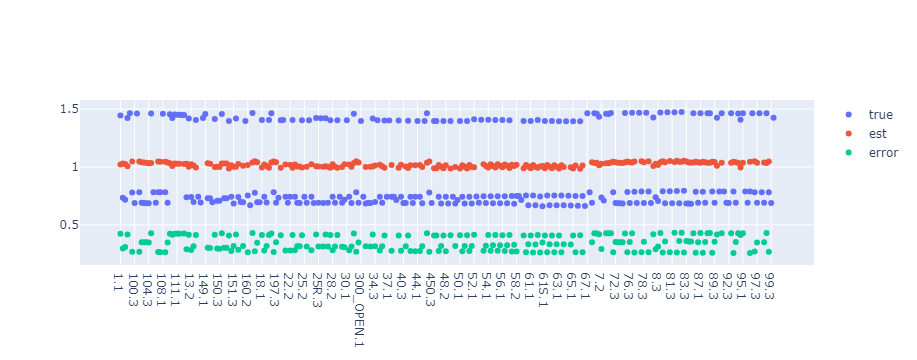

In [38]:
ts = dt.datetime(2018, 5, 1, 8)
true = true_voltages.loc[ts].abs()/base_voltages
est = est_voltages.loc[ts].abs()/base_voltages
error = (true - est).abs()

fig = make_subplots(rows=1,cols=1)
fig.add_trace(go.Scatter(name='true', x=true.index, y=true.values,mode='markers'), row=1,col=1)
fig.add_trace(go.Scatter(name='est',x=est.index, y=est.values,mode='markers'), row=1,col=1)
fig.add_trace(go.Scatter(name='error',x=error.index, y=error.values,mode='markers'), row=1,col=1)
fig.show()

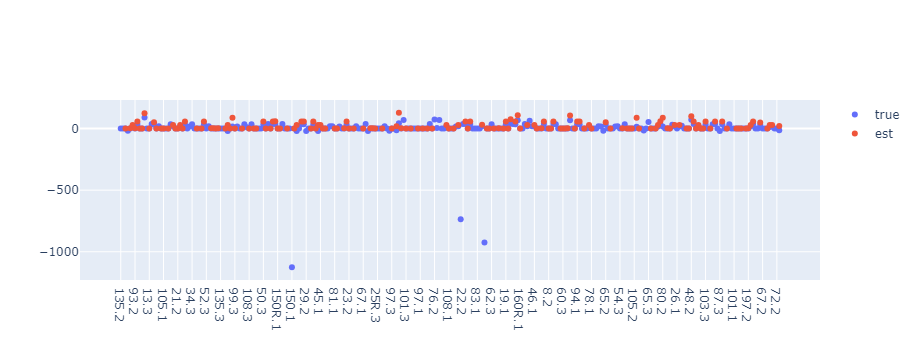

In [37]:
true = true_powers.loc[ts]
est = est_powers.loc[ts]

fig = make_subplots(rows=1,cols=1)
fig.add_trace(go.Scatter(name='true', x=true.index, y=true.values.real,mode='markers'), row=1,col=1)
fig.add_trace(go.Scatter(name='est',x=est.index, y=est.values.real,mode='markers'), row=1,col=1)
fig.show()